In [7]:
!pip install category_encoders

You should consider upgrading via the 'c:\users\nigel\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [16]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# encoders
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score

#pipeline
from sklearn.pipeline import make_pipeline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XBClassifier

from IPython.display import Image
from IPython.core.display import HTML 

ModuleNotFoundError: No module named 'xgboost'

In [2]:
def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, parse_dates=['date_recorded'], na_values=[-2e-08, 0]), 
                         pd.read_csv(tv_path)).set_index('date_recorded')

    else:
        df = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', parse_dates=['date_recorded']).set_index('date_recorded')
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        df[col] = df[col].replace(0, np.nan)
        df[col+'_MISSING'] = df[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    df = df.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    df = df.drop(columns=unusable_variance)
    
    
    # Edftract components from date_recorded, then drop the original column
    df['year_recorded'] = df.index.year
    df['month_recorded'] = df.index.month
    df['day_recorded'] = df.index.day

    # Engineer feature: how many years from construction_year to date_recorded
    df['years'] = df['year_recorded'] - df['construction_year']
    df['years_MISSING'] = df['years'].isnull()
    
    # return the wrangled dataframe
    return df

In [33]:
fm_path = 'train_features.csv'
tv_path = 'train_labels.csv'
df = wrangle(fm_path, tv_path)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47519 entries, 2013-02-27 to 2013-02-24
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   amount_tsh                 14189 non-null  float64
 1   funder                     44010 non-null  object 
 2   gps_height                 31245 non-null  float64
 3   installer                  43997 non-null  object 
 4   longitude                  46086 non-null  float64
 5   latitude                   46086 non-null  float64
 6   wpt_name                   47519 non-null  object 
 7   num_private                617 non-null    float64
 8   basin                      47519 non-null  object 
 9   subvillage                 47223 non-null  object 
 10  region                     47519 non-null  object 
 11  region_code                47519 non-null  int64  
 12  district_code              47500 non-null  float64
 13  lga                        47

In [35]:
# Split data into feature and target
target = 'status_group'
X,y = df.drop(columns=target),df[target]

In [36]:
# Split into train and validation
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.2,random_state=42)

In [37]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


# Roadmap of tree models

Decision Trees --> Random Forests --> Gradient Boosted Trees --> Extreme Gradient Boosted Trees (XGBoost)

In [29]:
# Build random forest classifier
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         RandomForestClassifier(n_jobs=-1,random_state=42,n_estimators=75))
model_rf.fit(X_train,y_train);

In [15]:
# Compute accuracy for the models
print('Training Accuracy:', model_rf.score(X_train,y_train))
print('Validation Accuracy:', model_rf.score(X_val,y_val))

Training Accuracy: 0.9999210837827174
Validation Accuracy: 0.8029250841750841


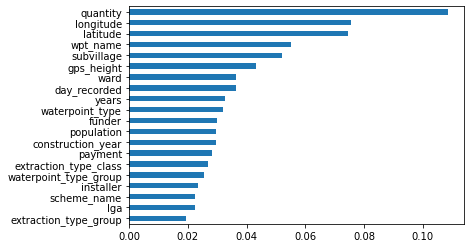

In [25]:
importances = model_rf.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(20).plot(kind='barh');

In [18]:
# Build gradient boosted 
model_gb = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         GradientBoostingClassifier(random_state = 42, n_estimators=75))
model_gb.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'wa

In [20]:
print('Training Accuracy:', model_gb.score(X_train,y_train))
print('Validation Accuracy:', model_gb.score(X_val,y_val))

Training Accuracy: 0.7537550966723662
Validation Accuracy: 0.7429503367003367


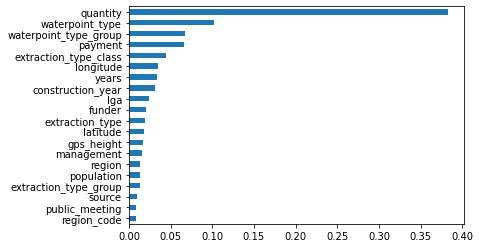

In [26]:
importances = model_gb.named_steps['gradientboostingclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(20).plot(kind='barh');

In [ ]:
# Build XGBoost boosted 
model_xgb = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         XGBClassifier(random_state = 42, n_estimators=75,n_jobs=-1))
model_xgb.fit(X_train,y_train)

In [ ]:
print('Training Accuracy:', model_xgb.score(X_train,y_train))
print('Validation Accuracy:', model_xgb.score(X_val,y_val))

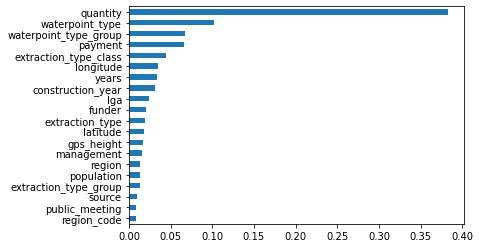

In [24]:
importances = model_gb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp =pd.Series(data=importances,index=feature_names).sort_values()
feat_imp.tail(20).plot(kind='barh');

In [47]:
# Use the random forest pipeline but train on X_train without the 'quantity' feature
# for cols in x_train.columns:
model_rf = make_pipeline( OrdinalEncoder(),
                         SimpleImputer(strategy = 'mean'),
                         RandomForestClassifier(n_jobs = -1, random_state=42, n_estimators=75))

model_rf.fit(X_train.drop(columns='waterpoint_type'),y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
                                          'data_type': dtype('O'),
                                          'mapping': groundwater    1
surface        2
unknown        3
NaN           -2
dtype: int64},
                                         {'col': 'waterpoint_t

In [48]:
print('Training Accuracy', model_rf.score(X_train.drop(columns='waterpoint_type'), y_train))
print('Validation Accuracy', model_rf.score(X_val.drop(columns='waterpoint_type'), y_val))

Training Accuracy 0.9998421675654346
Validation Accuracy 0.7997685185185185


In [51]:
model_dci = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         GradientBoostingClassifier(random_state = 42, n_estimators=75))

model_dci.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source',...
communal standpipe multiple    3
improved spring                4
other                          5
cattle trough                  6
dam                            7
NaN                           -2
dtype: int64},
                                         {'col': 'wa

In [55]:
print('Validation Accuracy:', model_dci.score(X_val,y_val))

Validation Accuracy: 0.7429503367003367


In [58]:
X_val_perm = X_val.copy()
X_val_perm['management'] = np.random.permutation(X_val_perm['management'])

In [59]:
print('Validation Accuracy:', model_dci.score(X_val_perm,y_val))

Validation Accuracy: 0.7429503367003367


In [60]:
from sklearn.inspection import permutation_importance

In [61]:
perm_imp = permutation_importance(model_dci,X_val,y_val,random_state=42)

In [69]:
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean',ascending=False)

In [70]:
df_perm

,imp_mean,imp_std
quantity,0.091709,0.003407
payment,0.018098,0.000880
waterpoint_type,0.014962,0.001977
extraction_type_class,0.005366,0.001538
district_code,0.004440,0.000385
population,0.004167,0.001225
years,0.003746,0.000612
lga,0.003620,0.000424
longitude,0.003430,0.001246
region,0.003325,0.001267


In [49]:
Image(url= "https://i.imgur.com/h17tMUU.png")

In [50]:
Image(url= "https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG")
## The below diagram explains how gradient boosted trees are trained for regression problems.